In [1]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# detect

In [3]:
# Load model checkpoint
#checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = 'checkpoint_ssd300-4804.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)
    det_labels_id = det_labels.copy()
    det_labels_id = det_labels_id[0].to('cpu').tolist()
    det_scores = det_scores[0].to('cpu').tolist()
    #print('det_boxes, det_labels, det_scores=',det_boxes, det_labels, det_scores)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')
    #print(det_boxes)
    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    #print(original_image.width, original_image.height)
    det_boxes = det_boxes * original_dims
    det_boxes

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image.copy()
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./Calibri Regular.ttf", 15)
    box_location_list = []

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness
        
       
        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
        box_location_list.append(box_location)
        #print(box_location)
        #print(det_labels,det_labels_id)
    del draw
    annotated_image = original_image
    return  original_image, box_location_list, det_labels_id, det_scores


if __name__ == '__main__':
    img_path = '../test_cdc/test_images/'
    pic_name = os.listdir('../test_cdc/test_images')
    name_list = []
    x_list = []
    y_list = []
    w_list = []
    h_list = []
    det_labels_list = []
    det_scores_list = []
    img_list = []
    for name in pic_name:  
        original_image = Image.open(img_path + name, mode='r')
        original_image = original_image.convert('RGB')
        try:
            #original_image, box_location_list, det_labels_id, det_scores = detect(original_image, min_score=0.01, max_overlap=0.5, top_k=200)#.show()
            original_image, box_location_list, det_labels_id, det_scores = detect(original_image, min_score=0.005, max_overlap=0.45, top_k=200)
            #annotated_image = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200).show()
            #print(box_location_list)
            img_list.append(original_image)
            re_name = np.repeat(name, len(det_labels_id))
            name_list.append(re_name)
            for box in box_location_list:
                x_list.append(round(box[0],6))
                y_list.append(round(box[1],6))
                w_list.append(round(box[2],6))
                h_list.append(round(box[3],6))
            det_labels_list.append(det_labels_id)
            det_scores_list.append(det_scores) 
        except:
            pass
    name_todic = list(itertools.chain(*name_list))
    det_labels_todic = list(itertools.chain(*det_labels_list))
    det_scores_todic = list(itertools.chain(*det_scores_list))
    test_dic = {}
    test_dic['image_filename'] = name_todic
    test_dic['label_id'] = det_labels_todic
    test_dic['x'] = x_list
    test_dic['y'] = y_list
    test_dic['w'] = w_list
    test_dic['h'] = h_list
    test_dic['confidence'] = det_scores_todic
    print('End')


Loaded checkpoint from epoch 4804.



/home/may/Deep Learning/Object Detection/a-PyTorch-Tutorial-to-Object-Detection-master/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/home/may/Deep Learning/Object Detection/a-PyTorch-Tutorial-to-Object-Detection-master/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


End


In [4]:
len(test_dic['image_filename']),len(test_dic['label_id']),len(test_dic['x']),len(test_dic['w']),len(test_dic['confidence'])


(50465, 50465, 50465, 50465, 50465)

# make output csv

In [5]:
def box_corner_to_center(ymin, xmin, ymax, xmax):
    """Convert from (upper_left, bottom_right) to (center, width, height)"""
    y1, x1, y2, x2 = ymin, xmin, ymax, xmax
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    
    return x1, y1, w, h

In [6]:
df = pd.DataFrame(test_dic) 
df["x"], df["y"], df["w"], df["h"] = box_corner_to_center(df["y"], df["x"], df["h"], df["w"])
#df["x"], df["y"], df["w"], df["h"] = box_corner_to_center(df["y"], df["x"], df["w"], df["h"])
#new_DF_trans = new_DF.drop(columns=["ymin", "xmin", "ymax", "xmax"])
#new_DF_trans = new_DF_trans[["image_filename","label_id","x","y","w","h","confidence"]]
df

,image_filename,label_id,x,y,w,h,confidence
0,201705232.jpg,2,336.789062,158.099106,63.911744,41.318390,0.273504
1,201705232.jpg,2,161.576096,179.975235,45.438537,53.462479,0.021035
2,201705232.jpg,2,243.256424,279.961487,59.200729,19.553436,0.011497
3,201705232.jpg,2,353.961426,183.993530,41.254120,32.894928,0.005461
4,201705232.jpg,3,336.789062,158.099106,63.911744,41.318390,0.075277
...,...,...,...,...,...,...,...
50460,2016051213.jpg,6,259.059326,62.309235,138.775635,219.995056,0.024047
50461,2016051213.jpg,6,190.393570,17.898626,147.075943,124.179484,0.005226
50462,2016051213.jpg,7,126.665947,45.855663,275.857765,250.297291,0.008755
50463,2016051213.jpg,8,91.345169,41.488777,303.738266,260.499382,0.074163


In [7]:
# df.loc[df["x"] < 0, "x"] = 0
# df.loc[df["y"] < 0, "y"] = 0
#df.loc[df["y"] == "bottle", "label_id"] = 2

In [8]:
#df = pd.DataFrame(test_dic) 
df.to_csv('./test_1733_try0.005_0.45.csv',index=False)

# plot detect img

In [67]:
pic_name= os.listdir('../test_cdc/test_images')

In [37]:
img_path = '../test_cdc/test_images/200801213.jpg'
original_image = Image.open(img_path, mode='r')
print(original_image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x600 at 0x7FD99F283100>


In [10]:
def detect_plot_use(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./Calibri Regular.ttf", 15)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labDels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image



In [19]:
img_path = '../test_cdc/test_images/200801213.jpg'
original_image = Image.open(img_path, mode='r')
print(original_image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x600 at 0x7FD99FE99910>


In [11]:
img = []
img_path = '../test_cdc/test_images/'
for i in pic_name[0:10]:
    original_image = Image.open(img_path+i, mode='r')
    annotated_image = detect_plot_use(original_image, min_score=0.2, max_overlap=0.5, top_k=200).show()
    img.append(original_image)

/home/may/Deep Learning/Object Detection/a-PyTorch-Tutorial-to-Object-Detection-master/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/home/may/Deep Learning/Object Detection/a-PyTorch-Tutorial-to-Object-Detection-master/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


201603232.jpg


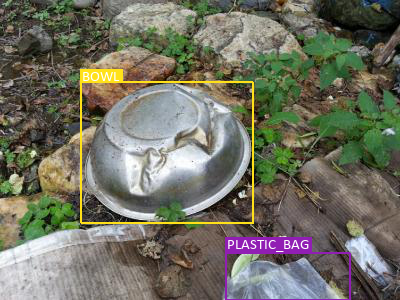

In [81]:
print(pic_name[6])
img[6]


201401026.jpg


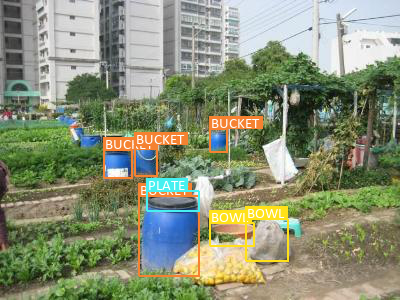

In [16]:
print(pic_name[8])
img[8]

In [ ]:
 with open('./mAP_dic.pickle', 'wb') as f:
                pickle.dump(mAP_dic, f)